In [1]:
import os
import sys
sys.path.append('../')

import random as rn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

import tensorflow as tf

from src.utils.models import define_model, train_and_pred
from src.utils.data import load_data

pd.options.display.max_columns = 100
%matplotlib inline
plt.style.use('seaborn')

/home/hardian_lawi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

def init_seeds(seed):

    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    
    K.set_session(sess)
    
    return sess

try:
    del sess
except:
    pass

print('creating new session.')
sess = init_seeds(0)

creating new session.


Using TensorFlow backend.


In [3]:
radiant_cols = ['hero_' + str(i) for i in range(5)]
dire_cols = ['hero_' + str(i) for i in range(5, 10)]
no_heroes = 116

radiants, dires, df = load_data()

## Tune Alpha L2 Regularization

alpha: 1e-05 

Instructions for updating:
Colocations handled automatically by placer.
Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.6004743965396959 ---- test: 0.5668480535789033
alpha: 0.0005 

Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.6039347007115948 ---- test: 0.5672945444397935
alpha: 0.001 

Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.6035858797265243 ---- test: 0.5714803962606391
alpha: 0.01 

Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.5711594809543743 ---- test: 0.5679921864099344
alpha: 0.05 

Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.5387191293428212 ---- test: 0.5386354123064043
alpha: 0.1 

Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.5386354123064043 ---- test: 0.5386354123064043
alpha: 0.5 

Average score
--------------------
custom_nn_l2_regularizer ======= train: 0.5386354

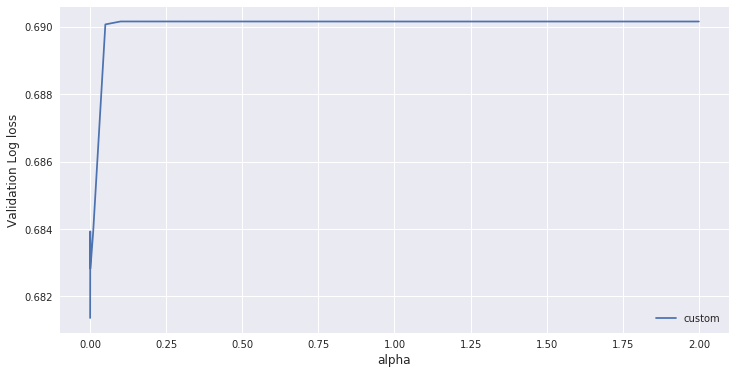

In [4]:
n_splits = 3
kf = KFold(n_splits, shuffle=True, random_state=10)

hs = {}

alpha_choices = [0.00001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]

for alpha in alpha_choices:
    
    hs[alpha] = {}

    avg_score = {}
    avg_threshold = 0
    
    print('=================================================')
    print('alpha:', alpha, '\n')
    
    for i, (train_idx, test_idx) in enumerate(kf.split(df)):

        X_train = [radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()]
        X_test = [radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()]

        y_train = df.radiant_win.iloc[train_idx].values
        y_test = df.radiant_win.iloc[test_idx].values

        models_dict = {
            'custom_nn_l2_regularizer': [
                define_model(name='custom_nn_l2_regularizer', optimizer='adam', 
                             seed=0, alpha=alpha),
            ],
        }

        if i not in hs[alpha]:
            hs[alpha][i] = {}

        for key, models in models_dict.items():

            if key not in avg_score:
                avg_score[key] = dict(train=0, test=0)

            temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
            temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
                accuracy_score(y_test, temp_preds[1] > 0.5)

            avg_score[key]['train'] += temp_scores[0]
            avg_score[key]['test'] += temp_scores[1]

            hs[alpha][i].update(temp_preds[2].history)

    ############################################################################

    print('Average score\n--------------------')
    for key, models in models_dict.items():
        print(key, '=======', 
              'train:', avg_score[key]['train'] / n_splits, '----',
              'test:', avg_score[key]['test'] / n_splits)
        
reform_2 = {(metric, alpha, fold): values 
          for alpha, interDict in hs.items() 
          for fold, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform_2 = pd.DataFrame(reform_2)

temp = []
for alpha in alpha_choices:
    temp.append(reform_2['val_loss'][alpha].min(axis=0).mean())
print('Best alpha:', alpha_choices[np.argmin(temp)], 'with loss', temp[np.argmin(temp)])

reform_2['val_loss'].min(axis=0).groupby(level=0).mean().plot(figsize=(12, 6))
plt.xlabel('alpha', fontsize=12)
plt.ylabel('Validation Log loss', fontsize=12)
plt.legend(['custom'])